In [ ]:
!pip install gdown >/dev/null
!pip install pytorch_lightning >/dev/null

ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 1.15.2 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.1 which is incompatible.


In [ ]:
import os
#Connect to Gdrive to store model checkpoints
from google.colab import drive
drive.mount('/content/drive',force_remount=True)



Mounted at /content/drive


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
from PIL import Image
import copy
import torch
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import callbacks, seed_everything

In [ ]:
!wget -O cData.zip https://hmgubox2.helmholtz-muenchen.de/index.php/s/mZCrqQcFxJgMcxD/download

--2021-04-28 23:15:37--  https://hmgubox2.helmholtz-muenchen.de/index.php/s/mZCrqQcFxJgMcxD/download
Resolving hmgubox2.helmholtz-muenchen.de (hmgubox2.helmholtz-muenchen.de)... 146.107.5.51
Connecting to hmgubox2.helmholtz-muenchen.de (hmgubox2.helmholtz-muenchen.de)|146.107.5.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cData.zip’

cData.zip               [              <=>   ]  17.07G  4.73MB/s    in 12m 39s 

2021-04-28 23:28:38 (23.0 MB/s) - ‘cData.zip’ saved [18328186115]



In [ ]:
import gdown
import zipfile


with zipfile.ZipFile("./cData.zip","r") as zip_ref:
    zip_ref.extractall("./covidData")


In [ ]:
!wget -O lung.zip https://tubcloud.tu-berlin.de/s/KFpifMdkJxDyRaK/download

--2021-04-29 09:18:01--  https://tubcloud.tu-berlin.de/s/KFpifMdkJxDyRaK/download
Resolving tubcloud.tu-berlin.de (tubcloud.tu-berlin.de)... 141.23.34.165
Connecting to tubcloud.tu-berlin.de (tubcloud.tu-berlin.de)|141.23.34.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘lung.zip’

lung.zip                [                 <=>] 187.25M  4.05MB/s    in 46s     

2021-04-29 09:18:49 (4.10 MB/s) - ‘lung.zip’ saved [196350303]



In [ ]:
import gdown
import zipfile


with zipfile.ZipFile("./lung.zip","r") as zip_ref:
    zip_ref.extractall("./lung")


In [ ]:
import gdown
import zipfile


with zipfile.ZipFile("lung/COVID_Datathon/masked_xrays_trainSet.zip","r") as zip_ref:
    zip_ref.extractall("./lungTrain")


In [ ]:
np.random.seed(10)
class CovidData(Dataset):
  def __init__(self,transform,type_):

    self.transform = transform
      
    self.type_=type_
    
    if self.type_=="train" or self.type_=="valid" or self.type_=="test":
      table_dir = "./covidData/HackathonCovidData/trainSet/trainSet.txt"
      self.image_path = "./covidData/HackathonCovidData/trainSet/normalizedImg"
      data =  pd.read_csv(table_dir)

      #Get indices for train and valid
      indices = [i for i in range(len(data))]
      v = 100 #100 samples for valid. Change as you want
      valid_indices = np.random.choice(indices, size=v,replace=False)
      t_d = [i for i in indices if i not in valid_indices]
      v_d = [i for i in indices if i in valid_indices]
      
      if self.type_ =="train":
        self.data = data.iloc[t_d]
      if self.type_ =="valid" or self.type_=="test":
        self.data = data.iloc[v_d]


    #elif self.type_ =="test":
     # table_dir = "./covidData/HackathonCovidData/testSet/testSet.txt"
     # self.image_path = "./covidData/HackathonCovidData/testSet/normalizedImg"
     # self.data =  pd.read_csv(table_dir)
  
  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()

    row = self.data.iloc[index]
  
    image_file=row['ImageFile']
    
   
    img = Image.open(os.path.join(self.image_path,image_file))
    img = img.convert('RGB')
  
    img = self.transform(img)
    
    label_str = row["Prognosis"]

  
      
    if label_str == "MILD":
        label=0
    elif label_str =="SEVERE":
        label=1
    else:
        label=-1
  

    row =  row.fillna(value={"Age":64.44,"Sex":0.34,"Temp_C":37.60,"Cough":0.51,"DifficultyInBreathing":0.50,"WBC":7.06,"CRP":40.68,"Fibrinogen":602.52,"LDH":368.17,"Ddimer":2500,"Ox_percentage":92.54,"PaO2":72.09,"SaO2":91.92,"pH":7.45,"CardiovascularDisease":0.28,"RespiratoryFailure":0.02}) 
    tabular = row[["Age","Sex","Temp_C","Cough","DifficultyInBreathing","WBC","CRP","Fibrinogen","LDH","Ddimer","Ox_percentage","PaO2","SaO2","pH","CardiovascularDisease","RespiratoryFailure"]]
    tabular = tabular.tolist()
    tabular = torch.FloatTensor(tabular)
    tab = tabular.view(1,tabular.size(0),1,1)

    tab_transform = transforms.Normalize(mean=(64.44,0.34,37.60,0.51,0.50,7.06,40.68,602.52,368.17,2500,92.54,72.09,91.92,7.45,0.28,0.02),std=(15.05,0.58,0.97,0.71,0.71,3.53,66.93,158.36,235.22,6743.13,7.00,26.11,8.24,0.06,0.53,0.14))
    tab_ = tab_transform(tab)
    tabl = tabular.view(tab_.size(1))

    return img, tabl, label
  def __len__(self):
    return len(self.data)

In [ ]:
class CovidClassifier(pl.LightningModule):
  def __init__( self):
    super().__init__()
   

    model = models.densenet121(pretrained=True)

    self.densenet = features = nn.Sequential(*(list(model.children())[:-1]))
   # num_ftrs = self.densenet.classifier.in_features
    #densenet.classifier = nn.Linear(num_ftrs,14)
    #namel = []
    #for name,layers in model.named_modules():
    #  print(name, ' : ',layers)
    
    #pyt_model = keras_to_pyt(kmodel, densenet)

    #print(namel)
    #for m in densenet.children():
    #  print(m)
    
    #densenet.load_state_dict(torch.load('brucechou1983_CheXNet_Keras_0.3.0_weights.h5'))
   
    #self.densenet.classifier = nn.Linear(num_ftrs,2)


    self.ln1 = nn.Linear(16, 8)
    self.relu = nn.ReLU()
    self.batchnorm = nn.BatchNorm1d(16)
    self.dropout = nn.Dropout(0.5)
    
    self.ln2 = nn.Linear(1032, 512)
    self.ln3 = nn.Linear(512, 256)
    self.ln4 = nn.Linear(256, 64)
    self.classifier = nn.Linear(64,1)
    self.sigmoid = nn.Sigmoid()
  def forward(self, img, tab):
  
    img = self.densenet(img)
    img = img.mean([2,3]) #1024 dim
     
    tab = self.ln1(tab)
    tab = self.relu(tab)

    x = torch.cat((img, tab), dim=1) #1032
   
    x=self.ln2(x)
    x = self.relu(x)
    x=self.ln3(x)
    x = self.relu(x)
    x=self.ln4(x)
    x = self.relu(x)
    x=self.dropout(x)
    x=self.classifier(x) 
    x=self.sigmoid(x) 
    x=torch.squeeze(x)
    return x
     

In [ ]:
 
tr = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
   
train_image_data = CovidData(tr,'train')
valid_image_data = CovidData(tr,'valid')
test_image_data = CovidData(tr,'test')

 

train_dataloader = DataLoader(train_image_data, batch_size=26,num_workers=4)
val_dataloader = DataLoader(valid_image_data, batch_size=26,num_workers=4)
test_dataloader = DataLoader(test_image_data, batch_size=26,num_workers=4)

 

In [ ]:
learning_rate = 0.0001
num_epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CovidClassifier()
weight_path= '/content/drive/MyDrive/HIDA/weights3'
with open(weight_path, "rb") as fp:   # Unpickling
    best_model_wts = pickle.load(fp)
model.load_state_dict(best_model_wts)
model = model.to(device)
criterion =nn.MSELoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                            steps_per_epoch=int(len(train_dataloader)),
                                            epochs=num_epochs,
                                            anneal_strategy='linear')


model= train_model(model,criterion,optimizer,scheduler,num_epochs=num_epochs,patience=100)


Epoch 0/199
----------
Loss: 0.0425 Acc: 24.9333 | Val Acc: 23.75
Saving best weights
Epoch 1/199
----------
Loss: 0.0341 Acc: 25.0000 | Val Acc: 23.75
Epoch 2/199
----------
Loss: 0.0275 Acc: 25.1333 | Val Acc: 23.75
Epoch 3/199
----------
Loss: 0.0258 Acc: 25.1333 | Val Acc: 23.75
Epoch 4/199
----------
Loss: 0.0194 Acc: 25.3000 | Val Acc: 23.75
Epoch 5/199
----------
Loss: 0.0165 Acc: 25.2333 | Val Acc: 23.75
Epoch 6/199
----------
Loss: 0.0132 Acc: 25.3333 | Val Acc: 23.25
Epoch 7/199
----------
Loss: 0.0145 Acc: 25.2333 | Val Acc: 24.0
Saving best weights
Epoch 8/199
----------
Loss: 0.0113 Acc: 25.3333 | Val Acc: 23.25
Epoch 9/199
----------
Loss: 0.0117 Acc: 25.2667 | Val Acc: 23.75
Epoch 10/199
----------
Loss: 0.0101 Acc: 25.3000 | Val Acc: 23.5
Epoch 11/199
----------
Loss: 0.0076 Acc: 25.2667 | Val Acc: 23.75
Epoch 12/199
----------
Loss: 0.0107 Acc: 25.2333 | Val Acc: 22.75
Epoch 13/199
----------
Loss: 0.0113 Acc: 25.2667 | Val Acc: 23.5
Epoch 14/199
----------
Loss: 0.007

In [ ]:
table_dir = "./covidData/HackathonCovidData/testSet/testSet.txt"
image_path = "./covidData/HackathonCovidData/testSet/normalizedImg"
data =  pd.read_csv(table_dir)

tr = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
   

patient =[]
result=[]

indices = [i for i in range(len(data))]
for ind in indices:
  row = data.iloc[ind]
  image_file=row['ImageFile']
  patient.append(row['PatientID'])
  if image_file==image_file:
    
    img = Image.open(os.path.join(image_path,image_file))
    img = img.convert('RGB')

    img = tr(img)
   


    row =  row.fillna(value={"Age":64.44,"Sex":0.34,"Temp_C":37.60,"Cough":0.51,"DifficultyInBreathing":0.50,"WBC":7.06,"CRP":40.68,"Fibrinogen":602.52,"LDH":368.17,"Ddimer":2500,"Ox_percentage":92.54,"PaO2":72.09,"SaO2":91.92,"pH":7.45,"CardiovascularDisease":0.28,"RespiratoryFailure":0.02}) 
    tabular = row[["Age","Sex","Temp_C","Cough","DifficultyInBreathing","WBC","CRP","Fibrinogen","LDH","Ddimer","Ox_percentage","PaO2","SaO2","pH","CardiovascularDisease","RespiratoryFailure"]]
    tabular = tabular.tolist()
    tabular = torch.FloatTensor(tabular)
    tab = tabular.view(1,tabular.size(0),1,1)

    tab_transform = transforms.Normalize(mean=(64.44,0.34,37.60,0.51,0.50,7.06,40.68,602.52,368.17,2500,92.54,72.09,91.92,7.45,0.28,0.02),std=(15.05,0.58,0.97,0.71,0.71,3.53,66.93,158.36,235.22,6743.13,7.00,26.11,8.24,0.06,0.53,0.14))
    tab_ = tab_transform(tab)
    tabl = tabular.view(tab_.size(1))
    img = torch.unsqueeze(img, 0)

    tabl = torch.unsqueeze(tabl, 0)
    img, tabl = img.to(device),tabl.to(device)
    pred = model(img,tabl)
    #print(pred)

    import torchviz
    from torchviz import make_dot

  

    make_dot(pred.mean(), params=dict(model.named_parameters())).render("attached", format="png")
    exit(1)
    result.append(pred.item())
  else:
    result.append(np.nan)

print(len(patient))
print(len(result))
DF=pd.DataFrame({
    'PatientID':patient,
    'result':result
})
DF.to_csv('results_Chris.csv')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.908705 to fit
tcmalloc: large alloc 1840594944 bytes == 0x560233c00000 @  0x7fe207186001 0x7fe20341d1fa 0x7fe20341d2ad 0x7fe2045a86df 0x7fe204a9f261 0x7fe206f1c468 0x7fe206f1ed53 0x56022c94f092 0x7fe2068d1bf7 0x56022c94f12a
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.908705 to fit
tcmalloc: large alloc 1840594944 bytes == 0x56553e3b8000 @  0x7f70d9b0a001 0x7f70d5da11fa 0x7f70d5da12ad 0x7f70d6f2c6df 0x7f70d7423261 0x7f70d98a0468 0x7f70d98a2d53 0x565537835092 0x7f70d9255bf7 0x56553783512a


KeyboardInterrupt: ignored

In [ ]:
!nvidia-smi --gpu-reset

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.


In [ ]:
def get_accuracy(pred,y):
  pred[pred>=0.5]=1
  pred[pred<0.5] = 0
  acc = torch.sum(pred==y)
  return acc


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs,patience):
   
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    pat=0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss=0
        running_corrects=0

        # Each epoch has a training and validation phase

        model.train()
            # Iterate over data.
        for image, tabular, y  in train_dataloader:
          y = y.float()
          image, tabular, y =image.to(device),tabular.to(device), y.to(device)
          # zero the parameter gradients
       
          y_pred = model(image, tabular)
          #y_pred = y_pred.double()

          loss = criterion(y_pred, y)
       


          loss.backward()
          optimizer.step()
          scheduler.step()

          optimizer.zero_grad()

          acc = get_accuracy(y_pred,y)

    
            # statistics
          running_loss += loss.item()
          running_corrects +=acc
     

        epoch_loss = running_loss / len(train_dataloader)
        epoch_acc = running_corrects.double() / len(train_dataloader)

       

        model.eval()
        val_corrects=0
      
        for image, tabular, y  in val_dataloader:
          image, tabular, y =image.to(device),tabular.to(device), y.to(device)
          y_pred = model(image, tabular)
          y_pred = y_pred.double()

       
          acc = get_accuracy(y_pred,y)

          val_corrects+=acc
        
        vepoch_acc =val_corrects.double() / len(val_dataloader)

        print('Loss: {:.4f} Acc: {:.4f} | Val Acc: {}'.format(epoch_loss, epoch_acc,vepoch_acc))
        if vepoch_acc > best_acc:
            pat=0
            print("Saving best weights")
            best_acc = vepoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            with open(weight_path,'wb') as fp:
              pickle.dump(best_model_wts,fp)
        else:
            pat+=1

        if pat==patience:
          print("Early stopping!")
          break
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params
-------------------------------------------
0 | densenet   | Sequential  | 7.0 M 
1 | ln1        | Linear      | 136   
2 | relu       | ReLU        | 0     
3 | batchnorm  | BatchNorm1d | 32    
4 | dropout    | Dropout     | 0     
5 | ln2        | Linear      | 528 K 
6 | ln3        | Linear      | 131 K 
7 | ln4        | Linear      | 16.4 K
8 | classifier | Linear      | 130   
-------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.523    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/usr/local/lib/pyt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


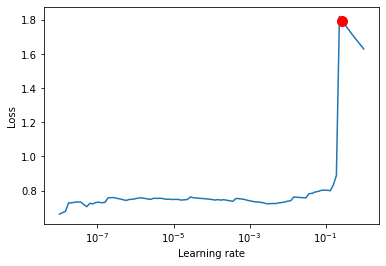

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params
-------------------------------------------
0 | densenet   | Sequential  | 7.0 M 
1 | ln1        | Linear      | 136   
2 | relu       | ReLU        | 0     
3 | batchnorm  | BatchNorm1d | 32    
4 | dropout    | Dropout     | 0     
5 | ln2        | Linear      | 528 K 
6 | ln3        | Linear      | 131 K 
7 | ln4        | Linear      | 16.4 K
8 | classifier | Linear      | 130   
-------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.523    Total estimated model params size (MB)


1

In [ ]:
seed_everything(42)
weight_path= '/content/drive/MyDrive/HIDA/weights2'
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
logger = pl_loggers.TensorBoardLogger("lightning_logs", name="multi_input")
early_stop_callback = callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=5000, patience=30, verbose=True, mode="min")
model = CovidClassifier()
trainer = pl.Trainer(gpus=1, logger=logger, callbacks=early_stop_callback,check_val_every_n_epoch=5,weights_save_path=weight_path,max_epochs=50)
lr_finder = trainer.tuner.lr_find(model)
fig = lr_finder.plot(suggest=True, show=True)
new_lr = lr_finder.suggestion()
model.hparams.lr = new_lr


trainer.fit(model,train_dataloader=train_dataloader,val_dataloaders=val_dataloader)


In [ ]:
trainer.test(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you defined a test_step but have no test_dataloader. Skipping test loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1

In [ ]:
!tensorboard --logdir=lightning_logs/multi_input/version_9

2021-04-29 12:31:11.235493: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=931fc9e7df52c5a0338ac1c7e672c6e3e6061664f255642a99a2d6e3f92ef6b6
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [ ]:

#make_dot(model).render("attached", format="png")

NameError: ignored

In [ ]:
%tensorflow_version 1.x
from keras.models import load_model
from __future__ import print_function
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
import cv2 
import keras
from os import listdir
import numpy as np
import matplotlib. pyplot as plt
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D,GlobalAveragePooling2D,Activation,BatchNormalization,Dropout,Concatenate
from keras.models import Model
from keras.applications import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam, Adamax
from keras.callbacks import LearningRateScheduler
from keras import optimizers
import tensorflow as tf
#Augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split
import urllib,math

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
densenet_ = DenseNet121(weights='brucechou1983_CheXNet_Keras_0.3.0_weights.h5',
        # weights = None ,
        include_top=True,
        input_shape=(224,224,3),classes=14
      )
      
m = densenet_.layers[-2].output
predictions = Dense(2, activation='softmax')(m)
kmodel = Model(inputs=densenet_.inputs, outputs=predictions)

In [ ]:
kmodel.load_weights('2_class_weight_3_7.h5')
weights=model.get_weights()

In [ ]:
adam = Adamax(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
kmodel.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy', precision, recall, fbeta_score])

In [ ]:
def keras_to_pyt(km, pm):
    weight_dict = dict()
  
    for layer in km.layers:
        print(layer)
        print(layer.get_config()['name'])
        print(np.asarray(layer.get_weights()).shape)
        if type(layer) is keras.layers.convolutional.Conv2D:
            print(len(layer.get_weights()))
            print(np.asarray(layer.get_weights()).shape)
            weight_dict[layer.get_config()['name'] + '.weight'] = np.transpose(layer.get_weights()[0], (3, 2, 0, 1))
            weight_dict[layer.get_config()['name'] + '.bias'] = layer.get_weights()[1]
        elif type(layer) is keras.layers.Dense:
            weight_dict[layer.get_config()['name'] + '.weight'] = np.transpose(layer.get_weights()[0], (1, 0))
            weight_dict[layer.get_config()['name'] + '.bias'] = layer.get_weights()[1]
    pyt_state_dict = pm.state_dict()
    for key in pyt_state_dict.keys():
        pyt_state_dict[key] = torch.from_numpy(weight_dict[key])
    pm.load_state_dict(pyt_state_dict)
    return pm

In [ ]:
from keras import backend as K

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))


def categorical_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=-1),
                          K.argmax(y_pred, axis=-1)))


def sparse_categorical_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.max(y_true, axis=-1),
                          K.cast(K.argmax(y_pred, axis=-1), K.floatx())))


def top_k_categorical_accuracy(y_true, y_pred, k=5):
    return K.mean(K.in_top_k(y_pred, K.argmax(y_true, axis=-1), k))


def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))


def mean_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))


def mean_absolute_percentage_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    return 100. * K.mean(diff)


def mean_squared_logarithmic_error(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.mean(K.square(first_log - second_log))


def hinge(y_true, y_pred):
    return K.mean(K.maximum(1. - y_true * y_pred, 0.))


def squared_hinge(y_true, y_pred):
    return K.mean(K.square(K.maximum(1. - y_true * y_pred, 0.)))


def categorical_crossentropy(y_true, y_pred):
    return K.mean(K.categorical_crossentropy(y_pred, y_true))


def sparse_categorical_crossentropy(y_true, y_pred):
    return K.mean(K.sparse_categorical_crossentropy(y_pred, y_true))


def binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true))


def kullback_leibler_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.mean(K.sum(y_true * K.log(y_true / y_pred), axis=-1))


def poisson(y_true, y_pred):
    return K.mean(y_pred - y_true * K.log(y_pred + K.epsilon()))


def cosine_proximity(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return -K.mean(y_true * y_pred)


def matthews_correlation(y_true, y_pred):
    """Matthews correlation metric.
    It is only computed as a batch-wise average, not globally.
    Computes the Matthews correlation coefficient measure for quality
    of binary classification problems.
    """
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [ ]:
tensorboard --logdir=lightning_logs

In [ ]:
state_dict = torch.load('2_class_weight_3_7.h5')
for k,v in state_dict.items():
  print(k)

UnpicklingError: ignored

In [ ]:
import pickle
from functools import *

model = torch.load('modelW.h5')

RuntimeError: ignored